In [1]:

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


import joblib

os.makedirs('outputs', exist_ok=True)
print("Setup complete.")


Setup complete.


In [3]:

df = pd.read_csv('/content/daily_trade_sentiment.csv', parse_dates=['date'], index_col='date')
df.index.name = 'date'
print("Daily dataframe shape:", df.shape)
df.head()


Daily dataframe shape: (188, 10)


,size_tokens_sum,size_tokens_mean,size_usd_sum,size_usd_mean,closed_pnl_sum,closed_pnl_mean,execution_price_mean,account_nunique,side_<lambda>,classification
date,,,,,,,,,,
2023-01-05,2.513000e-01,0.083767,477.00,159.000000,0.000000,0.000000,1898.133333,1,{'BUY': 3},Fear
2023-05-12,1.180901e+01,1.312112,50005.83,5556.203333,0.000000,0.000000,11038.300000,1,"{'BUY': 7, 'SELL': 2}",Neutral
2024-01-01,4.178787e+03,232.154813,264239.53,14679.973889,-129.531460,-7.196192,10373.330667,1,"{'BUY': 10, 'SELL': 8}",Greed
2024-01-02,4.498600e+04,7497.666667,2008.18,334.696667,0.000000,0.000000,0.076126,1,{'BUY': 6},Greed
2024-01-03,2.598468e+07,189669.167883,472974.70,3452.370073,8244.241409,60.176945,2.725657,1,"{'SELL': 100, 'BUY': 37}",Greed


In [4]:
print("Unique classifications:", df['classification'].unique())

if 'sent_num' not in df.columns:
    df['sent_num'] = df['classification'].map({'Greed':1, 'Fear':0})

df['target_next_sent'] = df['sent_num'].shift(-1)
df = df.dropna(subset=['target_next_sent'])
df['target_next_sent'] = df['target_next_sent'].astype(int)

print("Prepared dataset for modeling, shape:", df.shape)
df[['classification','sent_num','target_next_sent']].head()


Unique classifications: ['Fear' 'Neutral' 'Greed' 'Extreme Greed' 'Extreme Fear']
Prepared dataset for modeling, shape: (122, 12)


,classification,sent_num,target_next_sent
date,,,
2023-05-12,Neutral,NaN,1
2024-01-01,Greed,1.0,1
2024-01-02,Greed,1.0,1
2024-01-03,Greed,1.0,1
2024-01-04,Greed,1.0,1


In [5]:
lags = [1,2,3,7]
for lag in lags:
    if 'closed_pnl_sum' in df.columns:
        df[f'closedpnl_sum_lag_{lag}'] = df['closed_pnl_sum'].shift(lag)
    if 'size_usd_sum' in df.columns:
        df[f'sizeusd_sum_lag_{lag}'] = df['size_usd_sum'].shift(lag)

if 'closed_pnl_sum' in df.columns:
    df['closedpnl_rollstd_7'] = df['closed_pnl_sum'].rolling(7).std()

df.head()


,size_tokens_sum,size_tokens_mean,size_usd_sum,size_usd_mean,closed_pnl_sum,closed_pnl_mean,execution_price_mean,account_nunique,side_<lambda>,classification,...,target_next_sent,closedpnl_sum_lag_1,sizeusd_sum_lag_1,closedpnl_sum_lag_2,sizeusd_sum_lag_2,closedpnl_sum_lag_3,sizeusd_sum_lag_3,closedpnl_sum_lag_7,sizeusd_sum_lag_7,closedpnl_rollstd_7
date,,,,,,,,,,,,,,,,,,,,,
2023-05-12,1.180901e+01,1.312112,50005.83,5556.203333,0.000000,0.000000,11038.300000,1,"{'BUY': 7, 'SELL': 2}",Neutral,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01,4.178787e+03,232.154813,264239.53,14679.973889,-129.531460,-7.196192,10373.330667,1,"{'BUY': 10, 'SELL': 8}",Greed,...,1,0.000000,50005.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-02,4.498600e+04,7497.666667,2008.18,334.696667,0.000000,0.000000,0.076126,1,{'BUY': 6},Greed,...,1,-129.531460,264239.53,0.00000,50005.83,NaN,NaN,NaN,NaN,NaN
2024-01-03,2.598468e+07,189669.167883,472974.70,3452.370073,8244.241409,60.176945,2.725657,1,"{'SELL': 100, 'BUY': 37}",Greed,...,1,0.000000,2008.18,-129.53146,264239.53,0.00000,50005.83,NaN,NaN,NaN
2024-01-04,9.563430e+06,124200.394382,339470.47,4408.707403,2507.963406,32.570953,1332.227817,2,"{'SELL': 45, 'BUY': 32}",Greed,...,1,8244.241409,472974.70,0.00000,2008.18,-129.53146,264239.53,NaN,NaN,NaN


In [6]:
candidate_features = [col for col in df.columns if ('lag' in col) or ('rollstd' in col)]
for c in ['closed_pnl_sum','size_usd_sum','execution_price_mean','account_nunique','leverage_mean']:
    if c in df.columns:
        candidate_features.append(c)

features = [f for f in candidate_features if f in df.columns]
print("Using features:", features)

df_model = df.dropna(subset=features + ['target_next_sent']).copy()
print("Model dataset shape after dropping NA:", df_model.shape)

X = df_model[features]
y = df_model['target_next_sent']

split_idx = int(len(df_model)*0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Using features: ['closedpnl_sum_lag_1', 'sizeusd_sum_lag_1', 'closedpnl_sum_lag_2', 'sizeusd_sum_lag_2', 'closedpnl_sum_lag_3', 'sizeusd_sum_lag_3', 'closedpnl_sum_lag_7', 'sizeusd_sum_lag_7', 'closedpnl_rollstd_7', 'closed_pnl_sum', 'size_usd_sum', 'execution_price_mean', 'account_nunique']
Model dataset shape after dropping NA: (115, 21)
Train shape: (92, 13) Test shape: (23, 13)


In [7]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
y_proba = clf.predict_proba(X_test_s)[:,1]

print("Classification report:")
print(classification_report(y_test, y_pred))

roc = roc_auc_score(y_test, y_proba)
print("ROC AUC:", roc)

joblib.dump(clf, 'outputs/rf_sentiment_model.joblib')
joblib.dump(scaler, 'outputs/scaler_for_rf.joblib')
print("Saved model and scaler to outputs/")


Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.48      0.65        23

    accuracy                           0.48        23
   macro avg       0.50      0.24      0.32        23
weighted avg       1.00      0.48      0.65        23

ROC AUC: nan


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: 

Saved model and scaler to outputs/


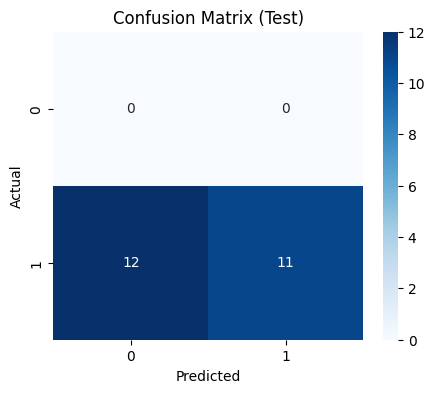

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


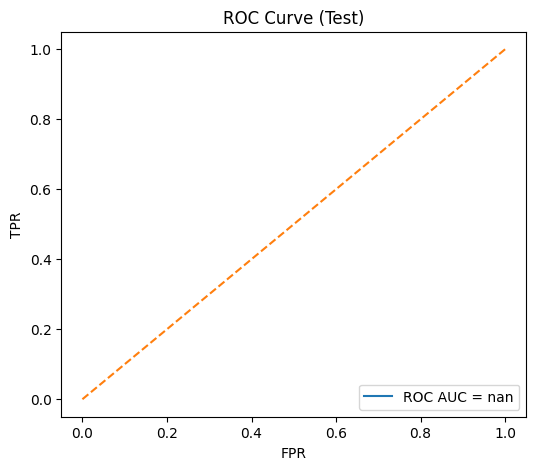

In [8]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('outputs/confusion_matrix.png')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve (Test)')
plt.legend(loc='lower right')
plt.savefig('outputs/roc_curve.png')
plt.show()


closedpnl_rollstd_7     0.210063
size_usd_sum            0.093394
sizeusd_sum_lag_1       0.088709
closedpnl_sum_lag_7     0.082396
sizeusd_sum_lag_2       0.074898
closedpnl_sum_lag_3     0.066756
closed_pnl_sum          0.065242
execution_price_mean    0.064067
sizeusd_sum_lag_3       0.062995
closedpnl_sum_lag_2     0.055356
sizeusd_sum_lag_7       0.053263
closedpnl_sum_lag_1     0.047811
account_nunique         0.035050
dtype: float64


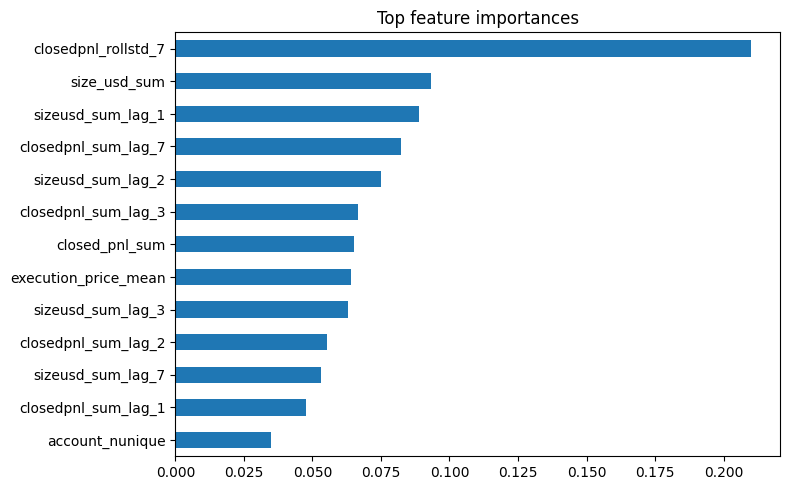

In [9]:
importances = clf.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)
print(feat_imp.head(20))

plt.figure(figsize=(8,5))
feat_imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top feature importances')
plt.tight_layout()
plt.savefig('outputs/feature_importances.png')
plt.show()


In [10]:
print("Top features (for report):")
for f,v in feat_imp.head(8).items():
    print(f"{f}: {v:.4f}")

print("\nModel notes for report:")
print("- Model: RandomForestClassifier with time-ordered train/test split.")
print("- Target: Next-day market sentiment (Greed=1, Fear=0).")
print("- Limitations: small dataset size, daily granularity, simple features. Use this as demo of concept, not production signal.")


Top features (for report):
closedpnl_rollstd_7: 0.2101
size_usd_sum: 0.0934
sizeusd_sum_lag_1: 0.0887
closedpnl_sum_lag_7: 0.0824
sizeusd_sum_lag_2: 0.0749
closedpnl_sum_lag_3: 0.0668
closed_pnl_sum: 0.0652
execution_price_mean: 0.0641

Model notes for report:
- Model: RandomForestClassifier with time-ordered train/test split.
- Target: Next-day market sentiment (Greed=1, Fear=0).
- Limitations: small dataset size, daily granularity, simple features. Use this as demo of concept, not production signal.


In [11]:
tr = pd.read_csv('/historical_data.csv', low_memory=False)

tr.columns = tr.columns.str.strip().str.lower().str.replace(' ', '_')

for c in ['size_tokens','size_usd','closed_pnl','fee','start_position']:
    if c in tr.columns:
        tr[c] = pd.to_numeric(tr[c], errors='coerce')

if 'timestamp_ist' in tr.columns:
    tr['timestamp_ist'] = pd.to_datetime(tr['timestamp_ist'], errors='coerce')

acc = tr.groupby('account').agg({
    'size_usd': ['sum','mean'],
    'size_tokens': ['sum','mean'],
    'closed_pnl': ['sum','mean'],
    'fee': 'sum',
    'trade_id': 'nunique',
    'timestamp_ist': ['min','max']
})

acc.columns = ['_'.join(map(str,c)).strip() for c in acc.columns]
acc = acc.reset_index()

acc['activity_days'] = (pd.to_datetime(acc['timestamp_ist_max']) - pd.to_datetime(acc['timestamp_ist_min'])).dt.days.fillna(0)
if 'trade_id_nunique' in acc.columns:
    acc = acc.rename(columns={'trade_id_nunique':'trades_count'})

acc = acc.fillna(0)
acc.head()


,account,size_usd_sum,size_usd_mean,size_tokens_sum,size_tokens_mean,closed_pnl_sum,closed_pnl_mean,fee_sum,trades_count,timestamp_ist_min,timestamp_ist_max,activity_days
0,0x513b8629fe877bb581bf244e326a047b249c4ff1,2.245983e+08,30645.144958,2.656409e+05,36.245182,485492.498294,66.251706,40008.449768,1400,2024-09-12 21:24:00,2025-12-04 23:55:00,448
1,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,3.051144e+06,2133.667364,2.986743e+06,2088.631406,403011.504159,281.826227,290.011048,782,2024-12-12 15:53:00,2025-12-04 22:18:00,357
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,1.677426e+06,2979.441776,6.627804e+06,11772.299287,67845.619531,120.507317,548.729265,407,2024-02-12 22:50:00,2025-12-04 20:07:00,660


In [27]:
cluster_features = []
for c in ['size_usd_sum','closed_pnl_sum','trades_count','fee_sum','activity_days','size_tokens_sum']:
    if c in acc.columns:
        cluster_features.append(c)

print("Using clustering features:", cluster_features)

scaler_acc = StandardScaler()
X_acc = scaler_acc.fit_transform(acc[cluster_features])

k = min(4, len(acc))
print("Using k =", k)

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(X_acc)
acc['cluster'] = kmeans.labels_

cluster_sizes = acc['cluster'].value_counts()

if k > 1 and (cluster_sizes >= 2).all():
    sil = silhouette_score(X_acc, kmeans.labels_)
    print(f"Silhouette score for k={k}: {sil:.3f}")
else:
    print("Silhouette score skipped: clusters too small (need ≥2 samples per cluster).")

acc.to_csv('outputs/accounts_clustered.csv', index=False)
print("Saved accounts_clustered.csv to outputs/")
acc.head()


Using clustering features: ['size_usd_sum', 'closed_pnl_sum', 'trades_count', 'fee_sum', 'activity_days', 'size_tokens_sum']
Using k = 3
Silhouette score skipped: clusters too small (need ≥2 samples per cluster).
Saved accounts_clustered.csv to outputs/


,account,size_usd_sum,size_usd_mean,size_tokens_sum,size_tokens_mean,closed_pnl_sum,closed_pnl_mean,fee_sum,trades_count,timestamp_ist_min,timestamp_ist_max,activity_days,cluster
0,0x513b8629fe877bb581bf244e326a047b249c4ff1,2.245983e+08,30645.144958,2.656409e+05,36.245182,485492.498294,66.251706,40008.449768,1400,2024-09-12 21:24:00,2025-12-04 23:55:00,448,2
1,0x72c6a4624e1dffa724e6d00d64ceae698af892a0,3.051144e+06,2133.667364,2.986743e+06,2088.631406,403011.504159,281.826227,290.011048,782,2024-12-12 15:53:00,2025-12-04 22:18:00,357,0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,1.677426e+06,2979.441776,6.627804e+06,11772.299287,67845.619531,120.507317,548.729265,407,2024-02-12 22:50:00,2025-12-04 20:07:00,660,1


Cluster median summary:


cluster,0,1,2
size_usd_sum,3.051144e+06,1.677426e+06,2.245983e+08
closed_pnl_sum,4.030115e+05,6.784562e+04,4.854925e+05
trades_count,7.820000e+02,4.070000e+02,1.400000e+03
fee_sum,2.900110e+02,5.487293e+02,4.000845e+04
activity_days,3.570000e+02,6.600000e+02,4.480000e+02
size_tokens_sum,2.986743e+06,6.627804e+06,2.656409e+05


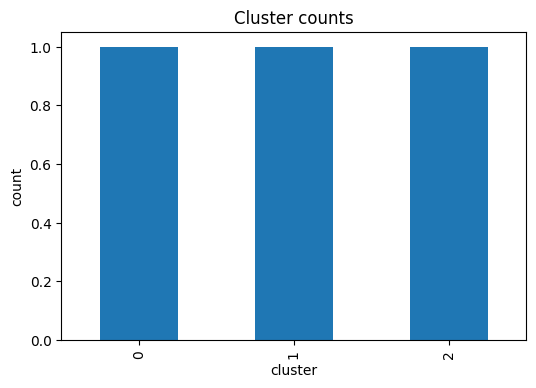

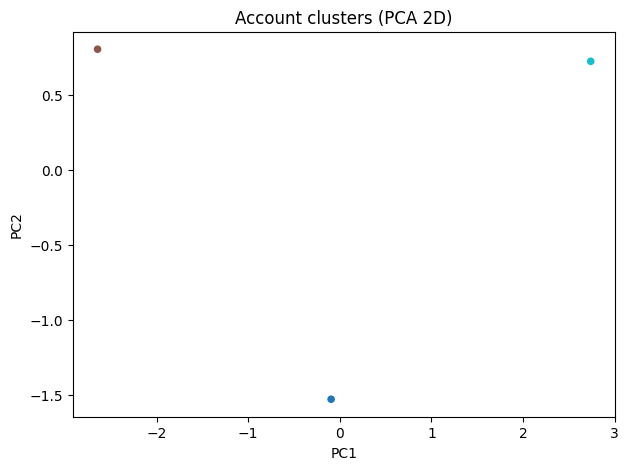

In [28]:
cluster_summary = acc.groupby('cluster')[cluster_features].median().T
print("Cluster median summary:")
display(cluster_summary)

plt.figure(figsize=(6,4))
acc['cluster'].value_counts().sort_index().plot(kind='bar')
plt.title('Cluster counts')
plt.xlabel('cluster')
plt.ylabel('count')
plt.savefig('outputs/cluster_counts.png')
plt.show()

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(X_acc)
plt.figure(figsize=(7,5))
plt.scatter(pc[:,0], pc[:,1], c=acc['cluster'], cmap='tab10', s=20)
plt.title('Account clusters (PCA 2D)')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.savefig('outputs/cluster_pca2d.png')
plt.show()


In [29]:
for f in os.listdir('outputs'):
    print(f)

print("\nFiles to include in report and GitHub outputs/:")
print("- outputs/rf_sentiment_model.joblib")
print("- outputs/scaler_for_rf.joblib")
print("- outputs/confusion_matrix.png")
print("- outputs/roc_curve.png")
print("- outputs/feature_importances.png")
print("- outputs/accounts_clustered.csv")
print("- outputs/cluster_counts.png")
print("- outputs/cluster_pca2d.png")


feature_importances.png
confusion_matrix.png
accounts_clustered.csv
cluster_counts.png
scaler_for_rf.joblib
cluster_pca2d.png
rf_sentiment_model.joblib
roc_curve.png

Files to include in report and GitHub outputs/:
- outputs/rf_sentiment_model.joblib
- outputs/scaler_for_rf.joblib
- outputs/confusion_matrix.png
- outputs/roc_curve.png
- outputs/feature_importances.png
- outputs/accounts_clustered.csv
- outputs/cluster_counts.png
- outputs/cluster_pca2d.png
